# HW3: Genetic Algorithm for Path Planning Problem

In [212]:
import time
import numpy as np
from typing import Tuple
from matplotlib import pyplot as plt
%matplotlib inline

In [213]:
DNA_SIZE = 10            # DNA length
POP_SIZE = 100           # population size
CROSS_RATE = 0.8         # mating probability (DNA crossover)
MUTATION_RATE = 0.003   # mutation probability
N_GENERATIONS = 200
X_BOUND = [0, 5]         # x upper and lower bounds
pop = np.random.randint(2, size=(POP_SIZE, DNA_SIZE)) #A 2D array where each row represents an individual's DNA, encoded as a binary sequence.

## Goal: 
Solve 100 sets of data X and find the maximum value **`F(X)`**
$$ F(x)= \sin(10x) \cdot x + \cos(2x) \cdot x $$

In [214]:
def F(x: np.float32) -> np.float32:
    return np.sin(10*x)*x + np.cos(2*x)*x

## HW3.1 Target Function
From x=0~5, draw the curve of this objective function

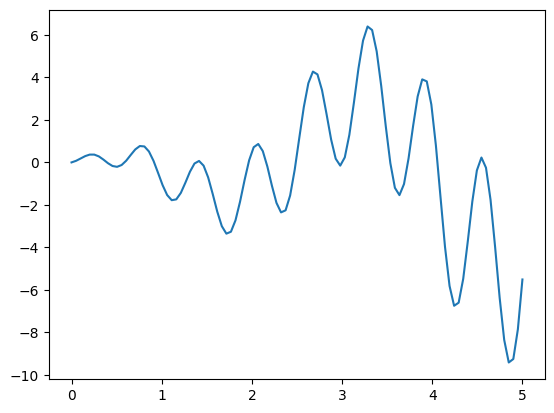

In [215]:
# TODO: draw the curve of this objective function
x_points = np.linspace(X_BOUND[0], X_BOUND[1], 100)
y_points = F(x_points)

plt.plot(x_points, y_points)

# Design Fitness Function
$$ fitness(pred) =\text{pred} + 10^{-3} - \min(\text{pred}) $$

This fitness function $pred + 10^{-3} - min(pred)$ is designed carefully to address common issues in algorithms and optimize the selection process. Here's a detailed explanation:

### **Explanation**:
1. **pred**: This represents the current fitness value (or prediction) of an individual in the population. The higher the fitness, the more likely the individual will be selected in a genetic algorithm.

2. **$10^{-3}$**: This small constant is added to ensure that the fitness value never becomes zero. Even when the `pred` value is very small or equal to the minimum in the population, this small constant prevents the fitness from being zero. It helps avoid numerical issues and ensures that each individual has a non-zero fitness, which is crucial in selection mechanisms that use fitness-based probabilities.

3. $- \min(\text{pred})$: Subtracting the minimum fitness value of the population helps normalize the fitness values. By shifting all fitness values so that the minimum fitness becomes close to zero, this highlights the difference between individuals. It ensures that the worst individuals are near zero fitness, making selection mechanisms more effective by promoting fitter individuals.

### **Why This Design?**

1. **Preventing Zero Fitness**: Adding a small constant ($10^{-3}$) ensures that no fitness value becomes zero or negative. This is important for algorithms that require positive fitness values, such as selection mechanisms in genetic algorithms that rely on proportional selection.

2. **Normalization**: By subtracting the minimum fitness value, the function ensures that the least fit individuals are near zero. This scaling helps selection mechanisms function more effectively, preventing the worst individuals from dominating and allowing fitter individuals to have a higher chance of selection.

3. **Fine Adjustment**: The addition of $10^{-3}$ is a small adjustment to ensure that no individual has exactly zero fitness, which is important for algorithms that require positive probabilities for selection.

### **Summary**:

This fitness function is designed to:
- Normalize fitness values by subtracting the minimum fitness.
- Ensure no individual has zero or negative fitness by adding a small constant.
- Smoothly scale fitness values to make sure selection mechanisms (like in genetic algorithms) work effectively, increasing the likelihood of selecting fitter individuals.

## You can also design other fitness functions.

## HW3.2 Fitness Function
Write the Fitness Function:
$$ \text{pred} + 10^{-3} - \min(\text{pred}) $$

In [216]:
def get_fitness(pred: np.ndarray[Tuple[int], np.float32]) -> np.ndarray[Tuple[int], np.float32]: 
    # TODO: Write the Fitness Function and return the fitness value
    """
    Input:
    1. pred: 1D array, size is the number of population, each value represent the predict value of i-th individual.
    Output:
    1. fitness: 1D array, size is the number of population, each value represent the fitness value of i-th individual. 
    """
    return pred + 1e-3 - np.min(pred)

## HW3.3 Representation
Design a function **`translateDNA(pop)`** to convert binary-encoded DNA (gene sequences) into a real number, used in genetic algorithms to map binary genes to a value within a specified range.

### **Input**:
- **`pop`**: A 2D array where each row represents an individual's DNA, encoded as a binary sequence.

### **Output**:
- A 1D array of real values, where the binary DNA has been converted to real numbers and scaled according to `X_BOUND[1]`.

### **Explanation**:
- The function converts the binary DNA representation into a real number by treating the binary sequence as a number in base-2, normalizing it by dividing by the maximum possible value, and scaling it to fit within the specified bounds (`X_BOUND[1]`).

In [217]:
def translateDNA(pop: np.ndarray[Tuple[int, int], np.int64]) -> np.ndarray[Tuple[int], np.float32]:
    # TODO: Write the translateDNA Function and return a 1D array of real values
    """
    Input:
    1. pop: A 2D array where each row represents an individual's DNA, encoded as a binary sequence.
    Output:
    1. scaled_real_number_of_individual: A 1D array of real values, where the binary DNA has been converted to real numbers and scaled according to `X_BOUND[1]`.
    """
    maximum_value = pow(2, DNA_SIZE) - 1
    real_number_vector = np.array([pow(2,i) for i in range(DNA_SIZE-1, -1, -1)], dtype=np.int64)    # [512, 256, ..., 2, 1]
    pop_real_number = np.matmul(pop, real_number_vector)
    normalized_pop_real_number = pop_real_number / maximum_value
    scaled_pop_real_number = normalized_pop_real_number * X_BOUND[1]
    return scaled_pop_real_number

# Testing
# test_pop = np.random.randint(2, size=(2, DNA_SIZE))
# translateDNA(test_pop)

# HW3.4 Selection
Write a function **`select(pop, fitness)`** to implement a natural selection process in a genetic algorithm. It selects individuals from the population (pop) based on their fitness values (fitness), where fitter individuals have a higher probability of being selected for the next generation. 

Tip: You can normalize fitness into a probability distribution using `p = fitness / fitness.sum()`, ensuring that the sum of all individuals equals 1. The higher the fitness of an individual, the greater its chance of being selected, but every individual still has a chance of being chosen.
### **Input**:
1. **`pop`**: A 2D array representing the population, where each row is an individual's genetic sequence (DNA).
2. **`fitness`**: A 1D array representing the fitness values of the individuals in the population.

### **Output**:
- **`pop[idx]`**: A 2D array representing the selected population for the next generation, with individuals chosen based on their fitness values.

In [218]:
def select(pop: np.ndarray[Tuple[int, int], np.int64], fitness: np.ndarray[Tuple[int], np.float32]) -> np.ndarray[Tuple[int, int], np.int64]:   # nature selection wrt pop's fitness
    # TODO: Write the select Function and return a 2D array representing the selected population for the next generation
    sum_of_fitness = np.sum(fitness)
    probabilities = fitness / sum_of_fitness    # list of probability [0.2, 0.9, ..., 0.3]
    pop_size = pop.shape[0]
    # select population number individual index by the probabilities
    selected_idx = np.random.choice(np.arange(pop_size), size=pop_size, p=probabilities, replace=True)

    return pop[selected_idx]    # return the selected population

# Test population: let's assume each individual in the population has 3 features (3D space)
# pop = np.array([
#     [0.1, 0.2, 0.3],
#     [0.4, 0.5, 0.6],
#     [0.7, 0.8, 0.9],
#     [1.0, 1.1, 1.2],
#     [1.3, 1.4, 1.5]
# ])

# # Corresponding fitness values for each individual in the population
# fitness = [0.2, 0.9, 0.3, 0.8, 0.6]

# # Call the selection function
# selected_pop = select(pop, fitness)

# # Print the selected population
# print("Original Population:")
# print(pop)

# print("\nFitness values:")
# print(fitness)

# print("\nSelected Population (based on fitness probabilities):")
# print(selected_pop)

## HW3.5 Crossover
Write a function **`crossover(parent, pop)`** to implement the crossover (mating) process in a genetic algorithm. During crossover, two individuals exchange some of their genetic material to produce a new individual (child).
### **Input**:
1. **`parent`**: A 1D array representing an individual's genetic sequence (DNA).
2. **`pop`**: A 2D array representing the population, where each row is an individual.

### **Output**:
- **`parent`**: A 1D array, either modified (after crossover) or unmodified (if no crossover occurs).


In [219]:
def crossover(parent: np.ndarray[Tuple[int], np.int64], pop: np.ndarray[Tuple[int, int], np.int64]) -> np.ndarray[Tuple[int], np.int64]:
    # TODO: Write the crossover Function and return a 1D array of parent
    # random choose one individual as another parent from population
    selected_parent_index = np.random.randint(0, pop.shape[0])
    selected_parent = pop[selected_parent_index, :]
    # based on CROSS_RATE to decide execute crossover or not
    if np.random.rand(1)[0] < CROSS_RATE:
    # if true, decide the crossover point, and then assign selected parent value to passed parent value after crossover point
        crossover_point_index = np.random.randint(0, DNA_SIZE)
        parent[crossover_point_index:] = selected_parent[crossover_point_index:]
    
    # return selected parent (it is child now)
    return parent

# Test
# pop = np.random.randint(2, size=(3, DNA_SIZE))
# parent = np.random.randint(2, size=(DNA_SIZE))
# crossover(parent, pop)

## HW3.6 Mutation
Write a function **`mutate()`** to perform a mutation operation in a genetic algorithm, which introduces small random changes in an individual's genetic sequence (DNA). Mutation helps maintain genetic diversity within the population.
### **Input**:
1. **`child`**: A 1D array representing an individual's genetic sequence (DNA), where each element is typically a binary value (0 or 1).

### **Output**:
- **`child`**: The modified genetic sequence after mutation, where certain genes may have flipped from 0 to 1 or from 1 to 0 based on the mutation rate.

### **Explanation**:
- The function iterates through each gene in the `child` DNA sequence. For each gene, with a probability determined by `MUTATION_RATE`, the gene may undergo mutation, flipping from 0 to 1 or from 1 to 0. This introduces genetic diversity into the population.


In [220]:
def mutate(child: np.ndarray[Tuple[int], np.int64]) -> np.ndarray[Tuple[int], np.int64]:
    # TODO: Write the mutation Function and return the child
    flip_bool = np.random.rand(DNA_SIZE) < MUTATION_RATE
    flip_bool = flip_bool.astype(int)
    child = np.bitwise_xor(child, flip_bool)
    return child

# Test
# child = np.random.randint(2, size=(DNA_SIZE))
# mutate(child)

## HW3.7 GA Function
Write a function GA() that implements a basic genetic algorithm (GA) that evolves a population over many generations to optimize the function F() based on the function you wrote above.
### **Input**:

1. **`N_GENERATIONS`**: An integer representing the number of generations (iterations) the genetic algorithm will run.
2. **`pop`**: A 2D array where each row represents an individual's DNA sequence encoded in binary (the initial population).

### **Output**:
- **`performance`**: A list that records the sum of fitness values (`F_values.sum()`) for each generation. This allows the user to analyze how the overall fitness of the population evolves across generations. Additionally, for each generation, a scatter plot is generated to visually represent the solutions' progression.
- **`time_per_iteration`**: A list used to record the computation time for each generation.

In [221]:
performance = []
time_per_iteration = []

def GA(N_GENERATIONS: int, pop: np.ndarray[Tuple[int, int], np.int64]):    
    # TODO: Write the GA Function that evolves a population over many generations to optimize the function F() based on the function you wrote above.
    for _ in range(N_GENERATIONS):
        start = time.time()
        F_values = F(translateDNA(pop))
        performance.append(F_values.sum())
        fitness = get_fitness(F_values)

        pop = select(pop, fitness)
        new_pop = pop.copy()
        for individual_id in range(POP_SIZE):
            parent = new_pop[individual_id,:]
            child = crossover(parent, pop)
            child = mutate(child)
            new_pop[individual_id,:] = child
        pop = new_pop
        
        end = time.time()
        time_per_iteration.append(end - start)


    return performance, time_per_iteration  # Return both performance and time per generation


In [222]:
performance = []
time_per_iteration = []
pop = np.random.randint(2, size=(POP_SIZE, DNA_SIZE))
GA(N_GENERATIONS,pop)

([np.float64(3.778648635371915),
  np.float64(78.92443896770067),
  np.float64(177.92246409305756),
  np.float64(200.7072137264453),
  np.float64(364.5524443992573),
  np.float64(460.1944290561414),
  np.float64(511.13294735134855),
  np.float64(530.1757487560628),
  np.float64(578.387339021063),
  np.float64(592.6985094084038),
  np.float64(602.069415263979),
  np.float64(594.9362315419949),
  np.float64(600.919223335142),
  np.float64(603.191826698734),
  np.float64(616.1150239109281),
  np.float64(631.1588491787584),
  np.float64(632.2288067518349),
  np.float64(608.3683952785052),
  np.float64(623.078914619451),
  np.float64(599.2455731048631),
  np.float64(620.8668018528765),
  np.float64(622.1223237224353),
  np.float64(626.98671824617),
  np.float64(616.8927138951202),
  np.float64(641.3093683215463),
  np.float64(636.7538579420112),
  np.float64(641.9386531871511),
  np.float64(624.4975810588542),
  np.float64(625.5631199407786),
  np.float64(638.8687996572338),
  np.float64(64

## HW3.8 Performance Visualization
Generates a line plot using matplotlib or other tool to visualize the performance of the genetic algorithm over multiple generations.

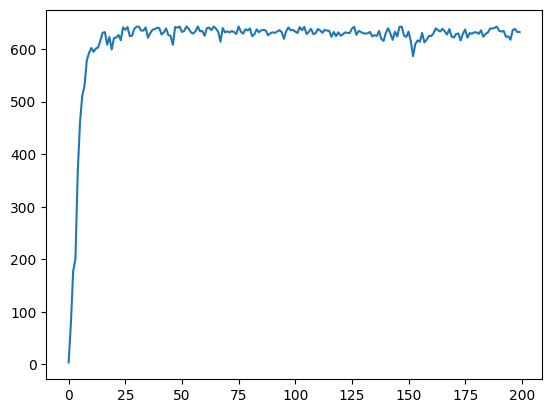

In [223]:
# TODO: Generates a line plot to visualize the genetic algorithm's performance across generations.
x = np.arange(0, N_GENERATIONS,1)
y = performance
plt.plot(x, y)

## HW3.9 Discuss1
Increase the mutation rate, follow the above steps, observe the performance, and provide a discussion.

In [224]:
MUTATION_RATE = 0.05 # > 0.003
performance = []
time_per_iteration = []
pop = np.random.randint(2, size=(POP_SIZE, DNA_SIZE))
GA(N_GENERATIONS,pop)

([np.float64(-78.4069773802284),
  np.float64(-76.32560800409759),
  np.float64(-7.066633529361589),
  np.float64(25.80578681508811),
  np.float64(71.27677173164112),
  np.float64(131.3226276754061),
  np.float64(169.5565079341531),
  np.float64(293.2959992579624),
  np.float64(291.57190066451767),
  np.float64(259.77077148617406),
  np.float64(335.2379371915648),
  np.float64(389.5410222177274),
  np.float64(371.5763138607365),
  np.float64(328.3401842457584),
  np.float64(362.4233821175508),
  np.float64(384.0453939187142),
  np.float64(423.39732019386554),
  np.float64(428.1543890056484),
  np.float64(469.29521346731303),
  np.float64(432.8246931362117),
  np.float64(416.7203399215158),
  np.float64(469.25577704642893),
  np.float64(404.8788823036339),
  np.float64(342.3649177151144),
  np.float64(292.23800617603797),
  np.float64(327.6822438581009),
  np.float64(378.3515173190524),
  np.float64(376.96773354735416),
  np.float64(420.7276381985902),
  np.float64(428.97561338679293),


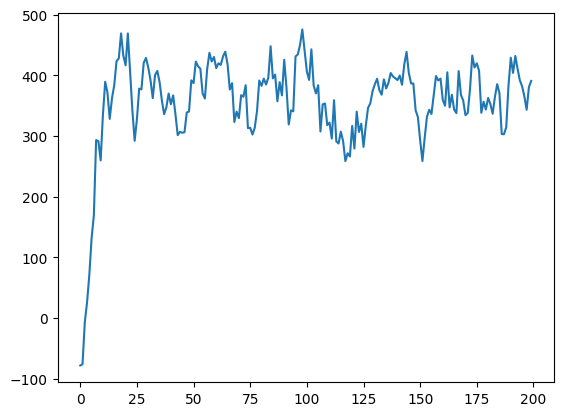

In [225]:
x = np.arange(0, N_GENERATIONS,1)
y = performance
plt.plot(x, y)

# HW 3.10 Discuss2
Based on the time taken for each generation, do you think GA is an efficient algorithm? Please compare it with traditional heuristic algorithms and modern machine learning methods in your explanation.

In [226]:
print(time_per_iteration)

[0.0011119842529296875, 0.0005459785461425781, 0.0004868507385253906, 0.0004811286926269531, 0.0004794597625732422, 0.0004718303680419922, 0.00046706199645996094, 0.00047087669372558594, 0.0004749298095703125, 0.00047278404235839844, 0.0004715919494628906, 0.0004703998565673828, 0.00047087669372558594, 0.0004723072052001953, 0.0004837512969970703, 0.0004677772521972656, 0.0004718303680419922, 0.0005199909210205078, 0.0004763603210449219, 0.00046896934509277344, 0.0004734992980957031, 0.00046944618225097656, 0.00047969818115234375, 0.0004699230194091797, 0.0004596710205078125, 0.0004730224609375, 0.000469207763671875, 0.0004782676696777344, 0.0004649162292480469, 0.0004620552062988281, 0.0004792213439941406, 0.0004718303680419922, 0.00046944618225097656, 0.00047278404235839844, 0.0004761219024658203, 0.0004711151123046875, 0.0004825592041015625, 0.00046181678771972656, 0.0004703998565673828, 0.00046753883361816406, 0.0004737377166748047, 0.0004680156707763672, 0.0004725456237792969, 0.0